In [ ]:
import os

os.chdir('..')

In [1]:
import os
import itertools
import pickle
import pandas as pd
import glob
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

import configs
from utils import laion_utils as laionu
from core.retrieve_image import download_image
from core.queries import query_name_def, QueryType

[nltk_data] Downloading package wordnet to /Users/alishri/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Settings

## Path

In [2]:
# LAION subset
laion_path = 'laion400m'
laion_until_part = 31
prefix = configs.LAIONConfig.SUBSET_SM_PREFIX

# Labels (maps)
labels_path = os.path.join('laion400m', 'processed', 'ilsvrc_labels')
lemma_labels_filter = 'lemma2laionindices(substring_matched_part*).pkl'
wnid_labels_filter = 'wnid2laionindices(substring_matched_part*).pkl'

lemma2wnid_path = os.path.join('ilsvrc2012', 'processed', 'lemma2wnid(unique_in_ilsvrc_ignored_empty_wnids).pkl')

In [3]:
# q_type = QueryType.A_CLEAR_PHOTO_OF_NAME_DEF
q_type = QueryType.NAME_DEF
sim_col = f'text_to_{q_type}_wnid_similarity'

# Init.

In [4]:
subset_file_name = prefix + laionu.get_laion_subset_file_name(0, laion_until_part)
subset_file_path = os.path.join(laion_path, subset_file_name)

# Load

## Load LAION subset

In [5]:
df = pd.read_parquet(subset_file_path)

df.head(3)

,SAMPLE_ID,URL,TEXT,HEIGHT,WIDTH,LICENSE,NSFW,similarity,a_photo_of_name_def_wnid,text_to_a_photo_of_name_def_wnid_similarity,a_photo_of_name_def_lemma,text_to_a_photo_of_name_def_lemma_similarity,name_def_wnid,text_to_name_def_wnid_similarity,a_clear_photo_of_name_def_wnid,text_to_a_clear_photo_of_name_def_wnid_similarity
60,2.105180e+12,https://rlv.zcache.com.au/archipelago144_i_mus...,"""Archipelago144 """"I Must Be A Mermaid"""" throw ...",324.0,324.0,?,UNLIKELY,0.331579,a photo of pillow which is a cushion to suppor...,0.573485,a photo of pillow which is a cushion to suppor...,0.573485,pillow which is a cushion to support the head ...,0.575911,a clear photo of pillow which is a cushion to ...,0.541188
69,1.127880e+12,http://images4-b.ravelrycache.com/uploads/Wool...,Oval_drum_small2,320.0,320.0,?,UNLIKELY,0.306868,a photo of drum which is a musical percussion ...,0.825175,a photo of drum which is a musical percussion ...,0.825175,drum which is a musical percussion instrument;...,0.853099,a clear photo of drum which is a musical percu...,0.757891
70,2.391401e+10,http://u.goal.com/175900/175958hp2.jpg,Senegal coach Joseph Koto to take revenge on C...,570.0,355.0,?,UNLIKELY,0.309802,a photo of passenger car which is a railcar wh...,0.545123,a photo of passenger car which is a railcar wh...,0.545123,passenger car which is a railcar where passeng...,0.557263,a clear photo of passenger car which is a rail...,0.534339


### Drop NSFW

In [6]:
df.loc[df[configs.LAIONConfig.NSFW_COL] != configs.LAIONConfig.SAFE_TAG, sim_col] = np.nan

## Load maps

In [7]:
lemma_maps_paths = glob.glob(os.path.join(labels_path, lemma_labels_filter))

lemma2laionindices = {}
for path in tqdm(lemma_maps_paths):
    with open(path, 'rb') as f:
        lemma2laionindices_i = pickle.load(f)
        
    for lemma, laionindices in lemma2laionindices_i.items():
        if lemma not in lemma2laionindices:
            lemma2laionindices[lemma] = []
        lemma2laionindices[lemma].extend(laionindices)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 19.82it/s]


In [8]:
wnid_maps_paths = glob.glob(os.path.join(labels_path, wnid_labels_filter))

wnid2laionindices = {}
for path in tqdm(wnid_maps_paths):
    with open(path, 'rb') as f:
        wnid2laionindices_i = pickle.load(f)
        
    for wnid, laionindices in wnid2laionindices_i.items():
        if wnid not in wnid2laionindices:
            wnid2laionindices[wnid] = []
        wnid2laionindices[wnid].extend(laionindices)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 21.77it/s]


In [9]:
with open(lemma2wnid_path, 'rb') as f:
    lemma2wnid = pickle.load(f)

### Find the inverse map

In [10]:
wnid2lemmas = {}
for lemma, wnid in lemma2wnid.items():
    if wnid not in wnid2lemmas:
        wnid2lemmas[wnid] = []
    wnid2lemmas[wnid].append(lemma)

# Plot distributions

In [11]:
wnid = 'n02125311'

print(query_name_def(wnid))

cougar which is large American feline resembling a lion


found 3911 cougar
found 11644 puma
found 0 mountain lion
found 23430 painter
found 310 Felis concolor


Text(0, 0.5, 'pdf')

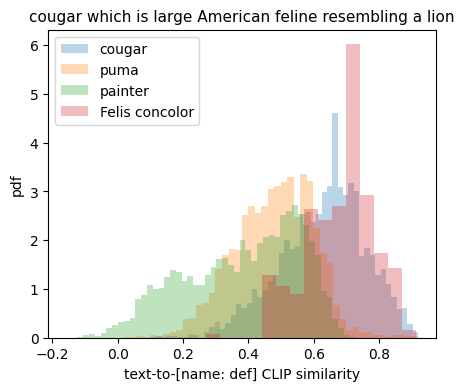

In [12]:
plt.figure(figsize=(5, 4))

lgnds = []
for lemma in wnid2lemmas[wnid]:
    if lemma not in lemma2laionindices:
        print(f'no record for {lemma}')
        continue
        
    sims = np.array(df.loc[lemma2laionindices[lemma], sim_col].tolist())
    urls = np.array(df.loc[lemma2laionindices[lemma], configs.LAIONConfig.URL_COL].tolist())

    mask = ~np.isnan(sims)

    n = np.sum(mask)
    print(f'found {n} {lemma}')
    if n == 0:
        continue
    
    plt.hist(sims[mask], bins=min([int(n/20), 50]), density=True, alpha=0.3)
    
    lgnds.append(lemma)
    
plt.legend(lgnds)

plt.title(query_name_def(wnid), fontsize=11)
plt.xlabel('text-to-[name: def] CLIP similarity')
plt.ylabel('pdf')

# plt.tight_layout()

# plt.savefig(os.path.join('figs', f'pdf_query-text-sim_{wnid}.pdf'))

# Plot examples from each quartile

In [13]:
qt_sims = np.linspace(0.5, 0.9, 6)

n_per_qt = 7

In [14]:
lemma = 'puma'

sims = np.array(df.loc[lemma2laionindices[lemma], sim_col].tolist())
urls = np.array(df.loc[lemma2laionindices[lemma], configs.LAIONConfig.URL_COL].tolist())

print(len(sims))

13546


## Choose the examples

In [15]:
bin2urls = {}
for i_qt, qt in enumerate(qt_sims[:-1]):
    qt_l = qt
    qt_h = qt_sims[i_qt + 1]
    
    qt_rng = np.logical_and(sims >= qt_l, sims < qt_h)
    
    if not np.any(qt_rng):
        print(f'bin {i_qt} has no examples.')
        continue
        
    bin2urls[i_qt] = np.random.choice(urls[qt_rng], size=np.minimum(n_per_qt, np.sum(qt_rng)), replace=False)
    
    print(f'bin {i_qt} has {np.sum(qt_rng)} examples.')

bin 0 has 2886 examples.
bin 1 has 2006 examples.
bin 2 has 331 examples.
bin 3 has 74 examples.
bin 4 has 37 examples.


## Fetch the images

In [16]:
bin2images = {b: [] for b in bin2urls}

for b in tqdm(bin2urls):
    for url in bin2urls[b]:
        try:
            image = download_image(url)
            bin2images[b].append(image)
        except Exception as e:
            continue

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.09s/it]


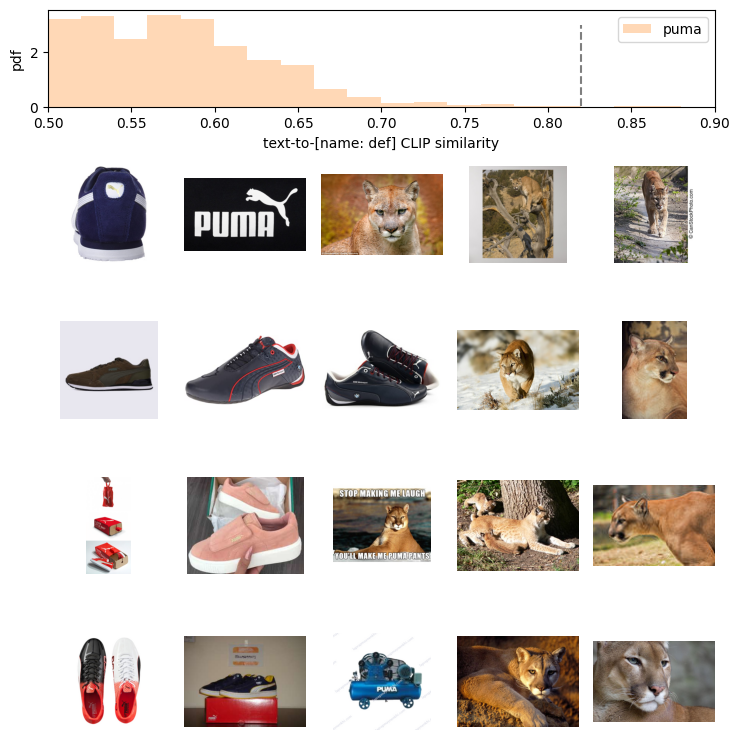

In [24]:
w = 1.5
h = 4
n_bin = len(bin2images)
chosen_sim_th = 0.82

plt.figure(figsize=(n_bin*w, (h + 1)*w))

for b, images in bin2images.items():
    for i_i, image in enumerate(images):
        if i_i >= h:
            continue
            
        plt.subplot(h + 1, n_bin, b + i_i*n_bin + 1 + 1*n_bin)
        
        plt.imshow(image)
        plt.axis('off')
        
color_cycle = itertools.cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
next(color_cycle)
cl = next(color_cycle)
plt.subplot(h + 1, 1, 1)
plt.hist(sims, bins=min([int(len(sims)/20), 50]), color=cl, alpha=0.3, density=True)
plt.legend([lemma])
plt.plot([chosen_sim_th]*2, [0.05, 3], 'k--', alpha=0.5)
plt.xlim((qt_sims[0], qt_sims[n_bin]))
plt.xlabel('text-to-[name: def] CLIP similarity')
plt.ylabel('pdf')


plt.tight_layout()

plt.savefig(os.path.join('figs', f'demo_query-text-sim_bins(lemma_{lemma}).pdf'))

# Sampling

In [25]:
sim_ths = np.linspace(0.5, 0.9, 20)
n_per_class_th = 1

In [26]:
n_class_per_th = []
n_sample_per_th = []

for sim_th in tqdm(sim_ths):
    n_class = 0
    laionindices_th = set()
    for wnid, laionindices in wnid2laionindices.items():
        sims = np.array(df.loc[laionindices, sim_col].tolist())
        if np.sum(sims > sim_th) >= n_per_class_th:
            n_class += 1
            laionindices_th.update(np.array(laionindices)[sims > sim_th])
                        
    n_class_per_th.append(n_class)
    n_sample_per_th.append(len(laionindices_th))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:17<00:00,  9.86s/it]


In [27]:
chosen_sim_th = 0.82

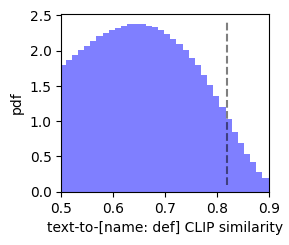

In [30]:
plt.figure(figsize=(3, 2.55))

plt.hist(df[sim_col], bins=100, density=True, color='b', alpha=0.5)
plt.plot([chosen_sim_th]*2, [0.1, 2.4], 'k--', alpha=0.5)
plt.xlim([sim_ths[0], sim_ths[-1]])
plt.xlabel('text-to-[name: def] CLIP similarity')
plt.ylabel('pdf')

plt.tight_layout()

plt.savefig(os.path.join('figs', 'text-query_sim_distribution_before_filtering.pdf'), bbox_inches='tight')

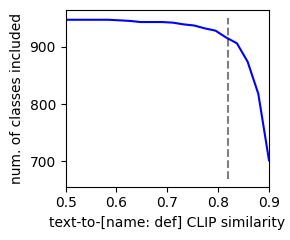

In [31]:
plt.figure(figsize=(3, 2.5))

plt.plot(sim_ths, n_class_per_th, 'b')
plt.plot([chosen_sim_th]*2, [670, 950], 'k--', alpha=0.5)
plt.xlim([sim_ths[0], sim_ths[-1]])
plt.xlabel('text-to-[name: def] CLIP similarity')
plt.ylabel('num. of classes included')

plt.tight_layout()

plt.savefig(os.path.join('figs', 'n-class_after_filtering.pdf'), bbox_inches='tight')

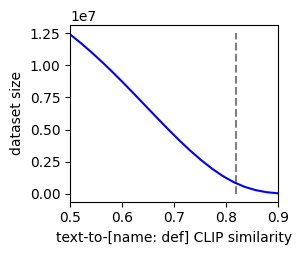

In [32]:
plt.figure(figsize=(3, 2.65))

plt.plot(sim_ths, n_sample_per_th, 'b')
plt.plot([chosen_sim_th]*2, [1.9e4, 1.25e7], 'k--', alpha=0.5)
plt.xlim([sim_ths[0], sim_ths[-1]])
plt.xlabel('text-to-[name: def] CLIP similarity')
plt.ylabel('dataset size')

plt.tight_layout()

plt.savefig(os.path.join('figs', 'dataset_size_after_filtering.pdf'), bbox_inches='tight')